# 熱中症患者数予測
#### 気象データから熱中症患者数を予測する回帰モデルを作成する

## Azure ML Service用の準備

In [33]:
import azureml
from azureml.core import Workspace, Run

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.57


In [34]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

azmls	japaneast	data-hack	japaneast


In [35]:
experiment_name = 'Heatstroke_patient_prediction'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

import pandas as pd

project_folder = './sample_projects/Heatstroke_patient_prediction'
output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = exp.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.57
Subscription ID,f8e38435-13b5-4b97-96c4-39b3bc918c54
Workspace Name,azmls
Resource Group,data-hack
Location,japaneast
Project Directory,./sample_projects/Heatstroke_patient_prediction
Experiment Name,Heatstroke_patient_prediction


## トレーニング用データをストレージにアップロード

In [36]:
import pandas as pd
df = pd.read_csv('./data/Heatstroke_patient_prediction_train_data.csv')

In [37]:
df.head(10)

,年月日,搬送人員（計）,最高気温(℃),平均気温(℃),最低気温(℃),日照時間(時間),平均風速(m/s),平均雲量(10分比),平均湿度(％),降水量の合計(mm),...,m前日最高気温との差,m前日平均気温との差,m前日最低気温との差,m最高気温移動平均(5日間),m平均気温移動平均(5日間),m体感温度移動平均(5日間),m不快指数移動平均(5日間),m前日の搬送人数,m搬送人数移動平均(5日間),年
0,7/2/2008 12:00:00 AM,4,26.90,23.70,21.10,8.30,3.10,9.50,70,0.00,...,1.40,1.90,2.50,24.82,21.90,19.75,69.15,0,0.00,2008
1,7/3/2008 12:00:00 AM,1,27.30,24.30,22.10,1.40,5.00,7.80,75,0.00,...,0.40,0.60,1.00,25.14,22.32,20.03,69.81,4,2.00,2008
2,7/4/2008 12:00:00 AM,14,31.60,26.50,23.10,8.70,3.70,7.80,77,16.00,...,4.30,2.20,1.00,25.38,22.50,20.17,70.18,1,1.67,2008
3,7/5/2008 12:00:00 AM,26,31.40,27.50,24.90,8.00,2.30,7.80,72,0.00,...,-0.20,1.00,1.80,27.20,23.60,22.28,71.77,14,4.75,2008
4,7/6/2008 12:00:00 AM,15,30.70,27.00,24.70,4.20,2.50,10.00,76,0.00,...,-0.70,-0.50,-0.20,28.54,24.76,23.81,73.54,26,9.00,2008
5,7/7/2008 12:00:00 AM,1,26.90,25.10,24.00,0.00,2.10,10.00,81,15.00,...,-3.80,-1.90,-0.70,29.58,25.80,25.13,75.23,15,12.00,2008
6,7/8/2008 12:00:00 AM,1,26.50,24.10,22.80,0.30,3.00,10.00,80,1.00,...,-0.40,-1.00,-1.20,29.58,26.08,25.38,75.89,1,11.40,2008
7,7/9/2008 12:00:00 AM,2,26.10,24.30,22.70,1.20,2.50,10.00,68,0.00,...,-0.40,0.20,-0.10,29.42,26.04,25.39,75.92,1,11.40,2008
8,7/10/2008 12:00:00 AM,2,27.80,24.60,22.10,2.50,2.30,9.00,70,0.00,...,1.70,0.30,-0.60,28.32,25.60,24.05,75.05,2,9.00,2008
9,7/11/2008 12:00:00 AM,6,29.40,26.00,23.50,5.50,3.10,8.80,71,0.00,...,1.60,1.40,1.40,27.60,25.02,23.20,74.13,2,4.20,2008


In [38]:
# get the default datastore
ds = ws.get_default_datastore()
print(ds.name, ds.datastore_type, ds.account_name, ds.container_name)

workspaceblobstore AzureBlob azmls1405322897 azureml-blobstore-5e66db71-88c8-45ad-9f28-9a6883032c4e


In [39]:
ds.upload_files(['./data/Heatstroke_patient_prediction_train_data.csv'],overwrite=True)

Uploading an estimated of 1 files
Uploading ./data/Heatstroke_patient_prediction_train_data.csv
Uploaded ./data/Heatstroke_patient_prediction_train_data.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_workspaceblobstore

## トレーニング実行用の ML Compute 作成

In [40]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your GPU cluster
cluster_name = "cpucluster"

# Verify that cluster does not exist already
try:
    cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D4_V2', #'Standard_NC6'
                                                           min_nodes=0,
                                                           max_nodes=8)
    cluster = ComputeTarget.create(ws, cluster_name, compute_config)

cluster.wait_for_completion(show_output=True)

Creating
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


## Automated ML 機能を使って予測モデル作成

In [41]:
import os
os.makedirs(project_folder, exist_ok=True)

### モデル学習用スクリプト作成

In [55]:
%%writefile $project_folder/get_data.py

import numpy as np
from azure.storage.blob import BlockBlobService
import pandas as pd
import os.path

def get_data():
    file_name = "Heatstroke_patient_prediction_train_data.csv"
    if not os.path.exists('./' + file_name) :
        account_name='azmls1405322897'
        account_key='0oGnArgZlzIs+YvO8bUoWFH61GXexPTFJoCWshh9xhdbGnLT0Khk6wZ5OpuZDkRe/BFDddcBK2rhVtkcTLnFHw=='
        container_name='azureml-blobstore-5e66db71-88c8-45ad-9f28-9a6883032c4e'
        blob_name=file_name
        
        service = BlockBlobService(account_name=account_name, account_key=account_key)
        service.get_blob_to_path(container_name, blob_name, file_name)
    
    df = pd.read_csv('./' + file_name)
    df = df.dropna(subset=["搬送人員（計）"])
    X_train = df.drop(columns=["年月日","年","月","搬送人員（計）"],axis=1)
    y_df = df["搬送人員（計）"]
    y_train = y_df.values

    return { "X" : X_train, "y" : y_train }

Overwriting ./sample_projects/Heatstroke_patient_prediction/get_data.py


### モデル学習実行環境定義

In [56]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies

# create a new RunConfig object
run_config = RunConfiguration(framework="python")

# Set compute target to AmlCompute target created in previous step
run_config.target = cluster.name

# enable Docker 
run_config.environment.docker.enabled = True
run_config.environment.docker.base_image = azureml.core.runconfig.DEFAULT_CPU_IMAGE

# specify CondaDependencies obj
run_config.environment.python.conda_dependencies = CondaDependencies.create(
    conda_packages=['numpy','pandas'], 
    pip_packages=['azureml-sdk[automl]', 'azure-storage'])

### automated ML 実行

In [57]:
from azureml.train.automl import AutoMLConfig
import logging

automated_ml_config = AutoMLConfig(task = 'regression',
                             primary_metric = 'normalized_mean_absolute_error',
                             iteration_timeout_minutes = 10,
                             iterations = 30,
                             preprocess = True,
                             verbosity = logging.INFO,
                             experiment_exit_score = 0,
                             path = project_folder,
                             data_script = project_folder + "/get_data.py",
                             run_configuration=run_config,
                             debug_log = 'automated_ml_errors.log',
                             n_cross_validations = 3,
                             max_concurrent_iterations = 4)

In [58]:
run_automl = exp.submit(automated_ml_config, show_output = False)
run_automl

Experiment,Id,Type,Status,Details Page,Docs Page
Heatstroke_patient_prediction,AutoML_0ce90130-1fb6-43b8-b4c5-a21ba3029be6,automl,Starting,Link to Azure Portal,Link to Documentation


In [59]:
from azureml.widgets import RunDetails
RunDetails(run_automl).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [77]:
%%time
# Shows output of the run on stdout.
run_automl.wait_for_completion(show_output=True)


****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         3   StandardScalerWrapper ExtremeRandomTrees       0:03:32       0.0267    0.0267
         2   StandardScalerWrapper RandomForest             0:02:41       0.0358    0.0267
         1   StandardScalerWrapper ElasticNet               0:00:56       0.0388    0.0267
         0   StandardScalerWrapper ElasticNet               0:01:48       0.0375    0.0267
         7   MinMaxScaler RandomForest                      0:03:30       0.0261    

{'runId': 'AutoML_0ce90130-1fb6-43b8-b4c5-a21ba3029be6',
 'target': 'cpucluster',
 'status': 'Completed',
 'startTimeUtc': '2019-09-24T06:36:35.809986Z',
 'endTimeUtc': '2019-09-24T06:50:43.101608Z',
 'properties': {'num_iterations': '30',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_mean_absolute_error',
  'train_split': '0',
  'MaxTimeSeconds': '600',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'cpucluster',
  'RawAMLSettingsString': "{'name': 'Heatstroke_patient_prediction', 'path': './sample_projects/Heatstroke_patient_prediction', 'subscription_id': 'f8e38435-13b5-4b97-96c4-39b3bc918c54', 'resource_group': 'data-hack', 'workspace_name': 'azmls', 'region': 'japaneast', 'compute_target': 'cpucluster', 'spark_service': None, 'iterations': 30, 'primary_metric': 'normalized_mean_absolute_error', 'task_type': 'regression', 'data_script': './sample_projects/Heatstroke_patient_prediction/get_data.py', 'valid

In [78]:
children = list(run_automl.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
explained_variance,0.80,0.79,0.75,0.86,0.78,0.76,0.83,0.87,0.79,0.75,...,0.85,0.80,0.79,0.79,0.78,0.82,0.78,0.85,0.88,0.87
mean_absolute_error,11.37,11.76,10.85,8.11,9.88,10.29,10.82,7.90,11.61,10.62,...,8.36,11.39,11.70,11.70,10.39,9.17,11.76,8.44,7.54,8.15
mean_absolute_percentage_error,176.84,179.92,98.48,66.15,70.19,74.61,165.89,60.23,173.47,76.14,...,66.43,177.38,181.74,178.50,91.09,72.66,170.77,69.14,61.61,79.17
median_absolute_error,7.88,8.17,4.96,3.69,4.00,3.87,7.47,3.30,7.80,4.18,...,3.74,7.99,8.01,8.14,4.63,4.08,8.04,3.83,3.35,4.10
normalized_mean_absolute_error,0.04,0.04,0.04,0.03,0.03,0.03,0.04,0.03,0.04,0.04,...,0.03,0.04,0.04,0.04,0.03,0.03,0.04,0.03,0.02,0.03
normalized_median_absolute_error,0.03,0.03,0.02,0.01,0.01,0.01,0.02,0.01,0.03,0.01,...,0.01,0.03,0.03,0.03,0.02,0.01,0.03,0.01,0.01,0.01
normalized_root_mean_squared_error,0.06,0.06,0.07,0.05,0.06,0.06,0.05,0.05,0.06,0.06,...,0.05,0.06,0.06,0.06,0.06,0.06,0.06,0.05,0.05,0.05
normalized_root_mean_squared_log_error,nan,nan,0.13,0.11,0.12,0.12,nan,0.10,nan,0.12,...,0.11,nan,nan,nan,0.13,0.11,nan,0.11,nan,nan
r2_score,0.80,0.79,0.75,0.86,0.78,0.76,0.83,0.87,0.79,0.75,...,0.85,0.80,0.79,0.79,0.77,0.82,0.78,0.85,0.88,0.87
root_mean_squared_error,17.65,18.27,20.09,14.70,18.67,19.32,16.52,14.44,18.22,19.59,...,15.37,17.68,18.22,18.21,18.84,16.93,18.59,15.39,13.87,14.13


## モデル登録

In [79]:
best_run, fitted_model = run_automl.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: Heatstroke_patient_prediction,
Id: AutoML_0ce90130-1fb6-43b8-b4c5-a21ba3029be6_28,
Type: azureml.scriptrun,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('7', Pipeline(memory=None,
     steps=[('minmax...285714285715, 0.07142857142857142, 0.07142857142857142, 0.07142857142857142, 0.07142857142857142]))]),
          stddev=None)


In [273]:
description = 'Heatstroke patient prediction Model'
name = "heatstroke_model"
model = best_run.register_model(model_name=name, description=description, model_path = "outputs/model.pkl")
print(model.name, model.id, model.version, sep='\t')

heatstroke_model	heatstroke_model:2	2


## デプロイされたモデルを取得

In [274]:
from azureml.core import Workspace
from azureml.core.model import Model
import os
ws = Workspace.from_config()
model = Model(ws, model.name)

model.download(target_dir=os.getcwd(), exist_ok=True)

# verify the downloaded model file
file_path = os.path.join(os.getcwd(), "model.pkl")

os.stat(file_path)
print(file_path)

/home/nbuser/library/model.pkl


## モデルの性能評価

### トレーニングデータ・テストデータの準備・処理

In [275]:
import pandas as pd
df_train = pd.read_csv('./data/Heatstroke_patient_prediction_train_data.csv') # トレーニングデータ(~2017年)の読み込み
df_test = pd.read_csv('./data/Heatstroke_patient_prediction_test_data.csv') # テストデータ(2018年のみ)の読み込み

In [276]:
df_train.head(10)

,年月日,搬送人員（計）,最高気温(℃),平均気温(℃),最低気温(℃),日照時間(時間),平均風速(m/s),平均雲量(10分比),平均湿度(％),降水量の合計(mm),...,m前日最高気温との差,m前日平均気温との差,m前日最低気温との差,m最高気温移動平均(5日間),m平均気温移動平均(5日間),m体感温度移動平均(5日間),m不快指数移動平均(5日間),m前日の搬送人数,m搬送人数移動平均(5日間),年
0,7/2/2008 12:00:00 AM,4,26.90,23.70,21.10,8.30,3.10,9.50,70,0.00,...,1.40,1.90,2.50,24.82,21.90,19.75,69.15,0,0.00,2008
1,7/3/2008 12:00:00 AM,1,27.30,24.30,22.10,1.40,5.00,7.80,75,0.00,...,0.40,0.60,1.00,25.14,22.32,20.03,69.81,4,2.00,2008
2,7/4/2008 12:00:00 AM,14,31.60,26.50,23.10,8.70,3.70,7.80,77,16.00,...,4.30,2.20,1.00,25.38,22.50,20.17,70.18,1,1.67,2008
3,7/5/2008 12:00:00 AM,26,31.40,27.50,24.90,8.00,2.30,7.80,72,0.00,...,-0.20,1.00,1.80,27.20,23.60,22.28,71.77,14,4.75,2008
4,7/6/2008 12:00:00 AM,15,30.70,27.00,24.70,4.20,2.50,10.00,76,0.00,...,-0.70,-0.50,-0.20,28.54,24.76,23.81,73.54,26,9.00,2008
5,7/7/2008 12:00:00 AM,1,26.90,25.10,24.00,0.00,2.10,10.00,81,15.00,...,-3.80,-1.90,-0.70,29.58,25.80,25.13,75.23,15,12.00,2008
6,7/8/2008 12:00:00 AM,1,26.50,24.10,22.80,0.30,3.00,10.00,80,1.00,...,-0.40,-1.00,-1.20,29.58,26.08,25.38,75.89,1,11.40,2008
7,7/9/2008 12:00:00 AM,2,26.10,24.30,22.70,1.20,2.50,10.00,68,0.00,...,-0.40,0.20,-0.10,29.42,26.04,25.39,75.92,1,11.40,2008
8,7/10/2008 12:00:00 AM,2,27.80,24.60,22.10,2.50,2.30,9.00,70,0.00,...,1.70,0.30,-0.60,28.32,25.60,24.05,75.05,2,9.00,2008
9,7/11/2008 12:00:00 AM,6,29.40,26.00,23.50,5.50,3.10,8.80,71,0.00,...,1.60,1.40,1.40,27.60,25.02,23.20,74.13,2,4.20,2008


In [277]:
df_test.head(10)

,年月日,搬送人員（計）,最高気温(℃),平均気温(℃),最低気温(℃),日照時間(時間),平均風速(m/s),平均雲量(10分比),平均湿度(％),降水量の合計(mm),...,夜_雷あり,m前日最高気温との差,m前日平均気温との差,m前日最低気温との差,m最高気温移動平均(5日間),m平均気温移動平均(5日間),m体感温度移動平均(5日間),m不快指数移動平均(5日間),m前日の搬送人数,m搬送人数移動平均(5日間)
0,5/2/2018 12:00:00 AM,0,25.30,20.40,17.10,2.90,3.20,10.00,79,3.50,...,0,-2.80,-1.90,0.40,25.50,20.36,19.32,66.10,16,16.00
1,5/3/2018 12:00:00 AM,4,27.40,21.90,16.80,1.90,6.20,10.00,77,14.00,...,0,2.10,1.50,-0.30,26.16,20.74,20.14,66.78,0,8.00
2,5/4/2018 12:00:00 AM,1,23.80,18.00,13.20,9.70,3.80,3.50,55,0.00,...,0,-3.60,-3.90,-3.60,26.42,21.10,20.63,67.63,4,6.67
3,5/5/2018 12:00:00 AM,5,24.30,18.30,11.50,12.40,3.30,1.80,53,0.00,...,0,0.50,0.30,-1.70,26.06,20.68,20.16,66.94,1,5.25
4,5/6/2018 12:00:00 AM,3,26.50,21.00,14.40,10.10,4.50,9.80,55,0.00,...,0,2.20,2.70,2.90,25.78,20.18,19.84,66.12,5,5.20
5,5/7/2018 12:00:00 AM,0,21.60,17.90,13.90,0.10,4.30,10.00,83,21.00,...,0,-4.90,-3.10,-0.50,25.46,19.92,19.30,65.71,3,2.60
6,5/8/2018 12:00:00 AM,0,14.60,12.90,11.40,0.00,3.10,10.00,92,10.50,...,0,-7.00,-5.00,-2.50,24.72,19.42,18.24,64.94,0,2.60
7,5/9/2018 12:00:00 AM,0,14.30,12.10,10.30,0.00,2.90,10.00,90,35.00,...,0,-0.30,-0.80,-1.10,22.16,17.62,15.27,62.06,0,1.80
8,5/10/2018 12:00:00 AM,0,15.80,12.10,10.00,3.20,1.80,6.30,84,9.00,...,0,1.50,0.00,-0.30,20.26,16.44,13.21,60.30,0,1.60
9,5/11/2018 12:00:00 AM,3,22.40,16.40,9.00,11.90,3.70,7.30,64,0.00,...,0,6.60,4.30,-1.00,18.56,15.20,11.71,58.50,0,0.60


In [278]:
df_train = df_train.dropna(subset=["搬送人員（計）"]) # 搬送人数情報がNaNのものを除去する

X_train = df_train.drop(columns=["年月日","年","月","搬送人員（計）"],axis=1)
y_train = df_train["搬送人員（計）"].values

In [279]:
X_test = df_test.drop(columns=["年月日","搬送人員（計）"],axis=1)
y_test = df_test["搬送人員（計）"].values

### Training dataとTest dataの残差プロット

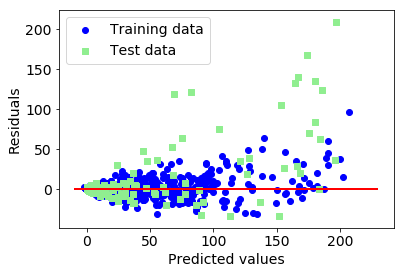

In [280]:
import matplotlib.pyplot as plt

y_pred_train = fitted_model.predict(X_train)
y_residual_train = y_train - y_pred_train
y_pred_test = fitted_model.predict(X_test)
y_residual_test = y_test - y_pred_test

plt.scatter(y_pred_train, y_residual_train, c='blue', marker='o', label='Training data')
plt.scatter(y_pred_test, y_residual_test, c='lightgreen', marker='s', label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=230, lw=2, color='red')
# plt.xlim([-10, 50])
plt.show()

### 平均二乗誤差 (MSE) と R^2

In [281]:
from sklearn.metrics import mean_squared_error, r2_score

print("MSE train: {: .3f}, test:{: .3f}".format(mean_squared_error(y_train, y_pred_train),
                                                mean_squared_error(y_test, y_pred_test)))
print("R^2 train: {: .3f}, test:{: .3f}".format(r2_score(y_train, y_pred_train),
                                                r2_score(y_test, y_pred_test)))

MSE train:  76.880, test: 1572.430
R^2 train:  0.952, test: 0.782


## モデルの解釈

In [271]:
!pip install --upgrade tqdm

Requirement already up-to-date: tqdm in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (4.36.1)
You should consider upgrading via the 'pip install --upgrade pip' command.


In [282]:
from azureml.train.automl.automlexplainer import explain_model

shap_values, expected_values, overall_summary, overall_imp, per_class_summary, per_class_imp = explain_model(fitted_model,
                         X_train,
                         X_test,
                         best_run,
                         features=X_train.columns,
                         y_train=y_train)

In [283]:
for xi, xj in zip(overall_imp, overall_summary):
    print(f"{xi}\t{xj}")

最高気温(℃)_MeanImputer	15.546994137521976
m前日の搬送人数_MeanImputer	13.463557287881608
c体感温度(℃)_MeanImputer	8.096240574499687
c不快指数_MeanImputer	3.0940617354825597
m搬送人数移動平均(5日間)_MeanImputer	2.2207491559566073
合計全天日射量(MJ/㎡)_MeanImputer	1.5381732788534037
平均気温(℃)_MeanImputer	1.158147589867968
日照時間(時間)_MeanImputer	0.939509887825598
m前日平均気温との差_MeanImputer	0.9123531668044126
m最高気温移動平均(5日間)_MeanImputer	0.537353852226354
m前日最低気温との差_MeanImputer	0.3759232998486926
平均蒸気圧(hPa)_MeanImputer	0.34314787813865694
m前日最高気温との差_MeanImputer	0.3237488611724101
m平均気温移動平均(5日間)_MeanImputer	0.2513367691871744
m体感温度移動平均(5日間)_MeanImputer	0.21305449071612723
平均雲量(10分比)_MeanImputer	0.2122275820951809
最小相対湿度(％)_MeanImputer	0.16376693552228447
最大風速(m/s)_MeanImputer	0.15251328260995106
m不快指数移動平均(5日間)_MeanImputer	0.14578058830532709
最大瞬間風速(m/s)_MeanImputer	0.13704668377719406
c最高最低気温差_MeanImputer	0.11759135769366724
昼_雨割合_MeanImputer	0.10640639908287892
昼_晴割合_MeanImputer	0.09676198140035776
平均風速(m/s)_MeanImputer	0.083905360206

↑結果：1番重要だと判断されたパラメータは、「最高気温(℃)」

### 上記のモデルの解釈の結果より1番目に重要と判断されたパラメータの散布図

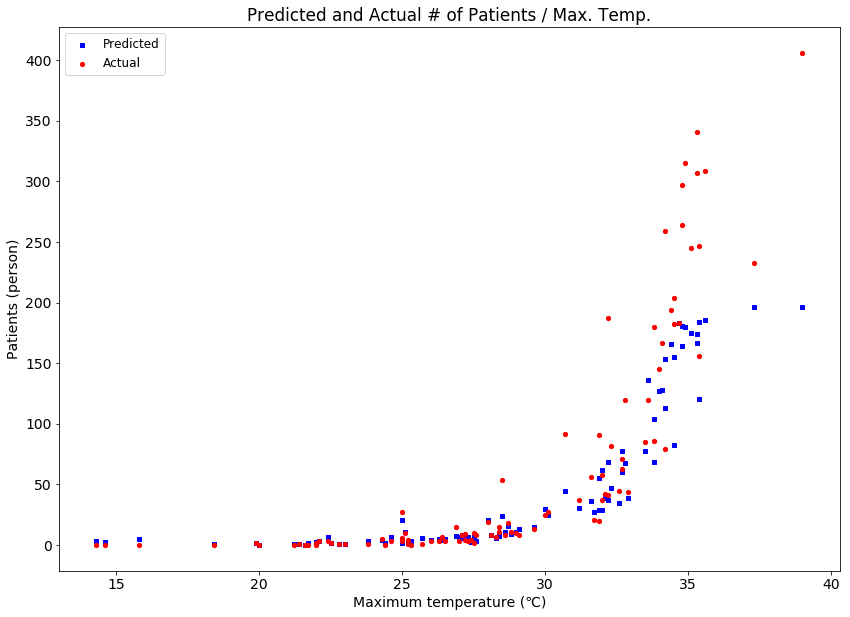

In [284]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "IPAexGothic"

fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(111)

y_predict = fitted_model.predict(X_test) 

x_vals = X_test["最高気温(℃)"].values
y_actual = y_test

ax1.scatter(x_vals[:100], y_predict[:100], s=18, c='b', marker="s", label='Predicted')
ax1.scatter(x_vals[:100], y_actual[:100], s=18, c='r', marker="o", label='Actual')

ax1.set_xlabel('Maximum temperature (℃)')
ax1.set_title('Predicted and Actual # of Patients / Max. Temp.')
ax1.set_ylabel('Patients (person)')

plt.legend(loc='upper left', prop={'size': 12})
plt.rcParams.update({'font.size': 14})
plt.show()

### 上記のモデルの解釈の結果より2番目重要と判断されたパラメータの散布図

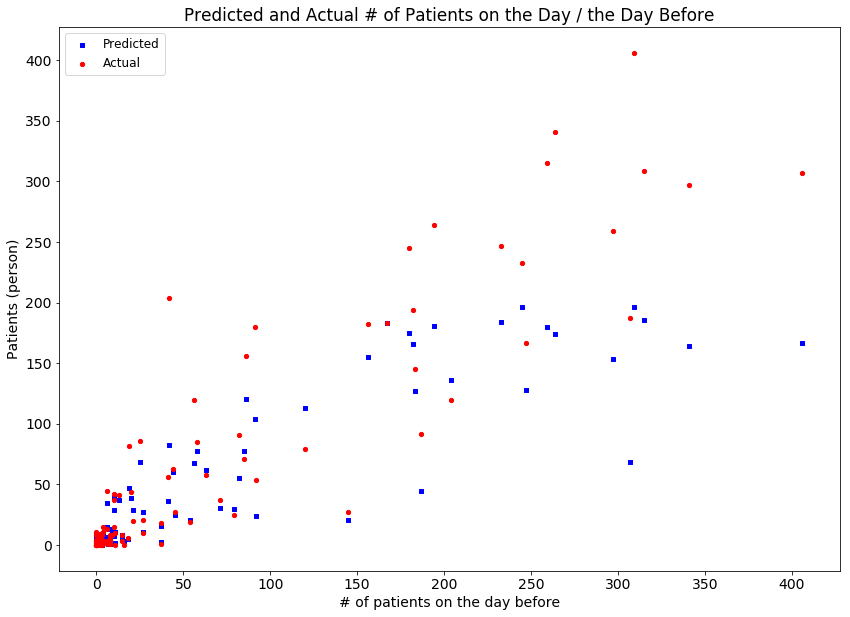

In [286]:
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(111)

# distance_vals = [x[4] for x in X_test.values]
x_vals = X_test["m前日の搬送人数"].values
y_actual = y_test

ax1.scatter(x_vals[:100], y_predict[:100], s=18, c='b', marker="s", label='Predicted')
ax1.scatter(x_vals[:100], y_actual[:100], s=18, c='r', marker="o", label='Actual')

ax1.set_xlabel('# of patients on the day before')
ax1.set_title('Predicted and Actual # of Patients on the Day / the Day Before')
ax1.set_ylabel('Patients (person)')

plt.legend(loc='upper left', prop={'size': 12})
plt.rcParams.update({'font.size': 14})
plt.show()

結果：予測値の方が搬送人数を低く見積もっている傾向が見受けられる

## Webサービスとしてデプロイ

### スコアリングスクリプトの作成(score.py)

In [289]:
%%writefile score.py
import json
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model
import azureml.train.automl

def init():
    global model
    # retrieve the path to the model file using the model name
    model_path = Model.get_model_path('heatstroke_model')
    model = joblib.load(model_path)
def run(raw_data):
    data = pd.read_json(json.loads(raw_data)['data'])
    y_hat = model.predict(data)   
    
    return y_hat.tolist()

Overwriting score.py


### Docker用環境ファイルの作成

In [290]:
from azureml.core.conda_dependencies import CondaDependencies

myenv = CondaDependencies.create(
    conda_packages=['numpy','pandas','scikit-learn'],
    pip_packages=['azureml-sdk[automl]'])

conda_env_file_name = 'myenv.yml'
myenv.save_to_file('.', conda_env_file_name)

with open("myenv.yml", "w") as f:
    f.write(myenv.serialize_to_string())

#### 環境ファイルの中身確認

In [291]:
with open("myenv.yml", "r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-sdk[automl]==1.0.57.*
- numpy
- pandas
- scikit-learn
channels:
- conda-forge



### Dockerイメージを作成

In [292]:
from azureml.core.model import Model
model = Model(ws, "heatstroke_model")
print(model.name)

heatstroke_model


In [293]:
%%time
from azureml.core.image import Image, ContainerImage

# configure the image
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                                  runtime="python", 
                                                  conda_file="myenv.yml")

image = Image.create(name = "heatstroke-image",
                              models = [model], # this is the registered model object
                              image_config = image_config,
                              workspace = ws)

image.wait_for_creation(show_output = True)

Creating image
Running..........................................................
Succeeded
Image creation operation finished for image heatstroke-image:3, operation "Succeeded"
CPU times: user 1.72 s, sys: 919 ms, total: 2.64 s
Wall time: 5min 16s


### ACI用環境ファイルの作成

In [296]:
from azureml.core.webservice import AciWebservice, Webservice

# 構成
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1,
                                               memory_gb=8,
                                               tags={"data": "heatstroke",
                                                     "method": "automl"},
                                               description='Heatstroke patient prediction Model')

### DockerイメージをACIにデプロイ

In [337]:
%%time
service = Webservice.deploy_from_image(workspace=ws,
                                       name='automl-heatstroke-prediction08',
                                       deployment_config=aciconfig,
                                       image=image)

service.wait_for_deployment(show_output=True)
print(service.state)

Creating service
Running.........................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy
CPU times: user 696 ms, sys: 392 ms, total: 1.09 s
Wall time: 2min 20s


#### WebサービスのURLを取得

In [338]:
print(service.scoring_uri)

http://74571212-a6d1-4661-9911-56f668e9be39.westus.azurecontainer.io/score


## 生の HTTP 要求を送信して Web サービスをテスト

### 2019年のデータを用いて、搬送人員（計）を予測

In [339]:
import requests
import pandas as pd
import io
import json

df_test = pd.read_csv('./data/Heatstroke_patient_prediction_predict_data.csv')

X_score = df_test.drop(["年月日","年","月","搬送人員（計）"], axis=1)
test_samples1 = json.dumps({"data":  X_score.to_json()})
headers = {'Content-Type': 'application/json'}
resp_str = requests.post(service.scoring_uri, test_samples1, headers=headers)

resp_json = json.dumps({"data":  resp_str.text})

df_purpose = pd.read_json(json.loads(resp_json)['data'])
df_purpose.columns = ["搬送人員（計）"]
df_purpose

,搬送人員（計）
0,22.91
1,19.60
2,61.05
3,59.70
4,60.04
5,59.99
6,62.78
7,68.41
8,59.31
9,56.89


### 説明変数と推論結果をファイルに書き出し

In [340]:
df_nonTrans = df_test.drop(["搬送人員（計）"], axis=1)

df_true = pd.concat([df_nonTrans,df_purpose],axis=1)
df_true
data_path = "./data/Heatstroke_patient_prediction_output.csv"
df.to_csv(data_path)

### Azure Blob Storageに格納

In [341]:
ds = ws.get_default_datastore()
print(f"{ds.name}\n{ds.datastore_type}\n{ds.account_name}\n{ds.container_name}\n{ds.account_key}")
ds.upload_files([data_path],overwrite=True)

workspaceblobstore
AzureBlob
azmls1405322897
azureml-blobstore-5e66db71-88c8-45ad-9f28-9a6883032c4e
0oGnArgZlzIs+YvO8bUoWFH61GXexPTFJoCWshh9xhdbGnLT0Khk6wZ5OpuZDkRe/BFDddcBK2rhVtkcTLnFHw==
Uploading an estimated of 1 files
Uploading ./data/Heatstroke_patient_prediction_output.csv
Uploaded ./data/Heatstroke_patient_prediction_output.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_workspaceblobstore

## リソースのクリーンアップ

In [333]:
service.delete()

### 参考文献
https://github.com/mimocihz/heatstroke_patient_prediction/blob/master/Heatstroke_patient_prediction.ipynb  
https://docs.microsoft.com/ja-jp/azure/machine-learning/service/tutorial-deploy-models-with-aml  
https://notebooks.azure.com/hiouchiy/projects/tutorial-ml/html/Sample-Deploy-Classification.ipynb  